#### Начнем с датасета с явно выраженными периодами:

This dataset describes the minimum daily temperatures over 10 years (1981-1990) in the city Melbourne, Australia.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv('raw.githubusercontent.com_jbrownlee_Datasets_master_daily-min-temperatures.csv')
df['Date'] = pd.to_datetime(df['Date'])

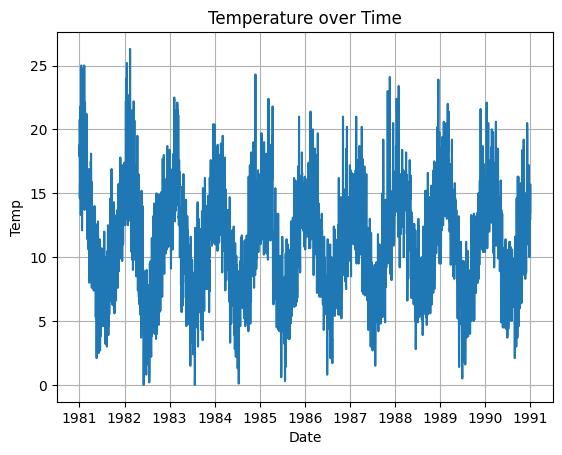

In [2]:
plt.plot(df['Date'], df['Temp'])
plt.xlabel('Date')
plt.ylabel('Temp')
plt.title('Temperature over Time')
plt.grid(True)
plt.show()

In [3]:
# Leave only first 1000 rows in dataset
df = df[:1000]

In [4]:
df

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8
...,...,...
995,1983-09-23,12.9
996,1983-09-24,7.7
997,1983-09-25,7.6
998,1983-09-26,3.5


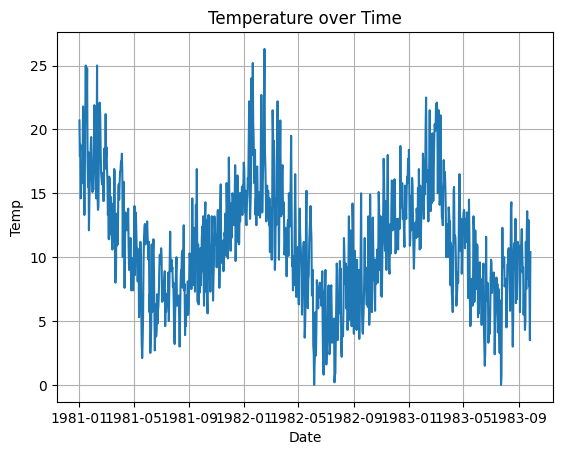

In [5]:
plt.plot(df['Date'], df['Temp'])
plt.xlabel('Date')
plt.ylabel('Temp')
plt.title('Temperature over Time')
plt.grid(True)
plt.show()

#### Для начала попробуем сами найти размерности

Размерность вложения будем искать с помощью Метода "False Nearest Neighbors"
Корреляционную размерность будем искать с помощью корреляционного интеграла

In [6]:
import numpy as np
import pandas as pd
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestNeighbors

# Определите начальную размерность вложения и задержку времени
embedding_dimension = 3
time_delay = 1

# Создайте фазовое пространство для корреляционной размерности
def create_phase_space(data, embedding_dimension, time_delay):
    N = len(data)
    phase_space = np.empty((N - (embedding_dimension - 1) * time_delay, embedding_dimension))
    for i in range(embedding_dimension):
        phase_space[:, i] = data[i * time_delay : N - (embedding_dimension - 1) * time_delay + i * time_delay]
    return phase_space

# Вычисление корреляционной размерности через корреляционный интеграл
def calculate_correlation_dimension(data, embedding_dimension, time_delay):
    phase_space = create_phase_space(data, embedding_dimension, time_delay)
    distances = pairwise_distances(phase_space, metric='euclidean')
    neigh = NearestNeighbors(n_neighbors=2)
    neigh.fit(phase_space)
    k_distances = neigh.kneighbors()[0][:, 1]
    C = np.sum(distances < k_distances[:, np.newaxis]) / (len(data) * (len(data) - 1))
    return C

# Вычисление размерности вложения с помощью метода False Nearest Neighbors
def false_nearest_neighbors(data, max_dimension, time_delay, threshold):
    dimensions = list(range(1, max_dimension + 1))
    false_neighbors = []

    for d in dimensions:
        phase_space = create_phase_space(data, d, time_delay)
        neighbors = NearestNeighbors(n_neighbors=1).fit(phase_space)
        distances, _ = neighbors.kneighbors(phase_space)
        max_radius = 10 * np.std(data)
        false_count = 0

        for i in range(len(phase_space)):
            for j in range(i + 1, len(phase_space)):
                if distances[i][j] < max_radius:
                    false_count += 1

        false_neighbors.append(false_count)

    optimal_dimension = dimensions[np.where(np.array(false_neighbors) / len(data) < threshold)[0][0]]

    return optimal_dimension

# Вычислите корреляционную размерность
corr_dim = calculate_correlation_dimension(df['Temp'], embedding_dimension, time_delay)
print(f"Correlation Dimension: {corr_dim}")

# Вычислите размерность вложения с помощью метода False Nearest Neighbors
max_embedding_dimension = 10  # Максимальная проверяемая размерность
threshold = 0.01  # Порог для определения ложных соседей
optimal_dimension = false_nearest_neighbors(df['Temp'], max_embedding_dimension, time_delay, threshold)
print(f"Optimal Embedding Dimension: {optimal_dimension}")


Correlation Dimension: 0.0024514514514514516


IndexError: ignored

#### Попробуем использовать библиотеку Giotto

Полезная ссылка: https://giotto-ai.github.io/gtda-docs/latest/notebooks/topology_time_series.html


In [7]:
!python -m pip install -U giotto-tda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.4/526.4 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.7 MB/s eta 0:00:00


In [8]:
from gtda.time_series import embedding, TakensEmbedding
optimal_time_delay, optimal_embedding_dimension = embedding.takens_embedding_optimal_parameters(
    df['Temp'], 100, 10, stride=1
    )
print(f"Optimal embedding dimension is {optimal_embedding_dimension} and time delay is {optimal_time_delay}")

Optimal embedding dimension is 5 and time delay is 70


#### Изобразим фазовую траекторию

In [9]:
from sklearn.manifold import TSNE

phase_space = TakensEmbedding(optimal_time_delay, optimal_embedding_dimension).fit_transform(df['Temp'].values.reshape(1, -1))[0]

# Создайте экземпляр t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)

# Преобразуйте фазовую траекторию в двумерное пространство
tsne_results = tsne.fit_transform(phase_space)

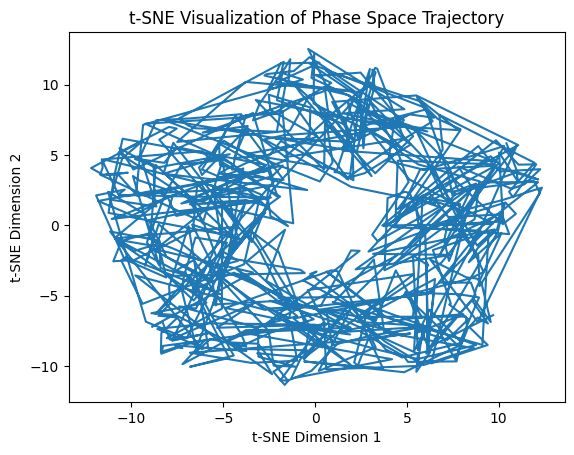

In [10]:
import matplotlib.pyplot as plt

# Создайте график фазовой траектории
plt.plot(tsne_results[:, 0], tsne_results[:, 1])
plt.title('t-SNE Visualization of Phase Space Trajectory')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

#### Попробуем трехмерный график

In [11]:
phase_traj = TakensEmbedding(optimal_time_delay, optimal_embedding_dimension).fit_transform(df['Temp'].values.reshape(1, -1))[0]
tsne = TSNE(n_components=3)
phase_traj_proj = tsne.fit_transform(phase_traj)

In [12]:
import plotly.express

fig = plotly.express.line_3d(pd.DataFrame(phase_traj_proj, columns=['x', 'y', 'z']), x="x", y="y", z="z")

fig.show()

#### Теперь временной ряд без периодов

еще полезная ссылка
https://towardsdatascience.com/time-series-forecasting-with-dynamical-systems-methods-fa4afdf16fd0

In [13]:
df2 = pd.read_csv('BBG00B3T3HD3.csv')[:1000]
df2

,close,high,low,open,volume,time
0,28.83,28.87,28.170,28.60,2746634,2017-01-03 07:00:00+00:00
1,30.26,30.30,29.020,29.02,3339520,2017-01-04 07:00:00+00:00
2,30.65,30.93,30.115,30.18,2444552,2017-01-05 07:00:00+00:00
3,30.68,31.10,30.310,30.69,2086333,2017-01-06 07:00:00+00:00
4,29.48,30.88,29.215,30.88,4205059,2017-01-09 07:00:00+00:00
...,...,...,...,...,...,...
995,24.01,24.10,22.400,22.90,742314,2020-12-10 07:00:00+00:00
996,22.84,24.19,22.200,24.05,658513,2020-12-11 07:00:00+00:00
997,21.76,23.40,21.670,22.90,702137,2020-12-14 07:00:00+00:00
998,22.17,22.54,20.700,21.98,519049,2020-12-15 07:00:00+00:00


In [14]:
from gtda.time_series import embedding, TakensEmbedding
optimal_time_delay, optimal_embedding_dimension = embedding.takens_embedding_optimal_parameters(
    df2['close'], 100, 10, stride=1
    )
print(f"Optimal embedding dimension is {optimal_embedding_dimension} and time delay is {optimal_time_delay}")

Optimal embedding dimension is 9 and time delay is 60


In [15]:
from sklearn.manifold import TSNE

phase_space = TakensEmbedding(optimal_time_delay, optimal_embedding_dimension).fit_transform(df2['close'].values.reshape(1, -1))[0]

# Создайте экземпляр t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)

# Преобразуйте фазовую траекторию в двумерное пространство
tsne_results = tsne.fit_transform(phase_space)

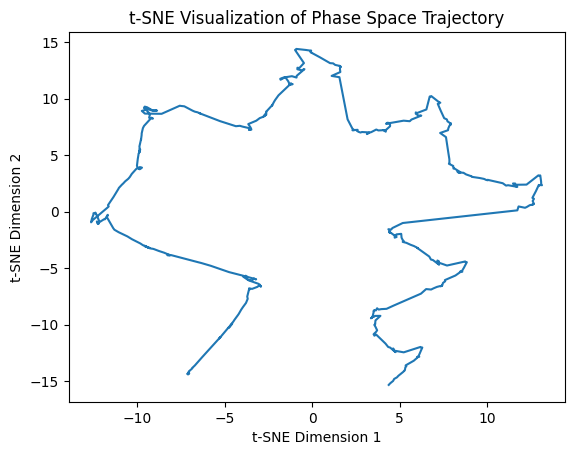

In [16]:
import matplotlib.pyplot as plt

# Создайте график фазовой траектории
plt.plot(tsne_results[:, 0], tsne_results[:, 1])
plt.title('t-SNE Visualization of Phase Space Trajectory')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

In [17]:
phase_traj = TakensEmbedding(optimal_time_delay, optimal_embedding_dimension).fit_transform(df2['close'].values.reshape(1, -1))[0]
tsne = TSNE(n_components=3)
phase_traj_proj = tsne.fit_transform(phase_traj)

In [18]:
import plotly.express

fig = plotly.express.line_3d(pd.DataFrame(phase_traj_proj, columns=['x', 'y', 'z']), x="x", y="y", z="z")

fig.show()

#### ЛР2

In [19]:
from gtda.time_series import embedding, TakensEmbedding
optimal_time_delay, optimal_embedding_dimension = embedding.takens_embedding_optimal_parameters(
    df['Temp'], 100, 10, stride=1
    )
print(f"Optimal embedding dimension is {optimal_embedding_dimension} and time delay is {optimal_time_delay}")

phase_space = TakensEmbedding(optimal_time_delay, optimal_embedding_dimension).fit_transform(df['Temp'].values.reshape(1, -1))[0]

Optimal embedding dimension is 5 and time delay is 70


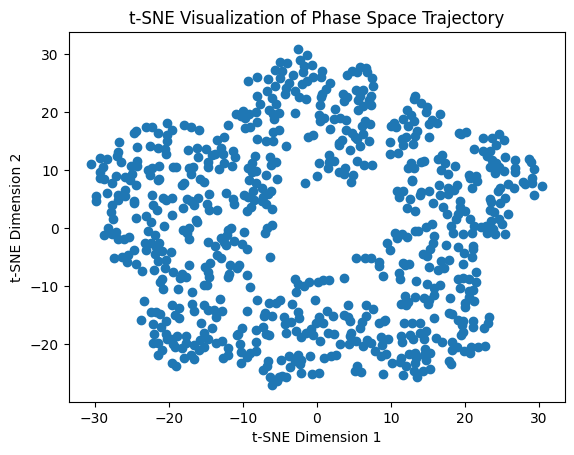

In [20]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(phase_space)
# Создайте график фазовой траектории
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
plt.title('t-SNE Visualization of Phase Space Trajectory')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

Побьем на кластеры первый датасет с помощью AgglomerativeClustering

In [21]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=4, linkage='ward', metric='euclidean')

clustering.fit(phase_space)

AgglomerativeClustering(metric='euclidean', n_clusters=4)

In [22]:
cluster_df = pd.concat([pd.DataFrame(phase_space, columns=[i for i in range(5)]), pd.DataFrame(clustering.labels_.reshape(-1, 1), columns=['cluster'])], axis=1)

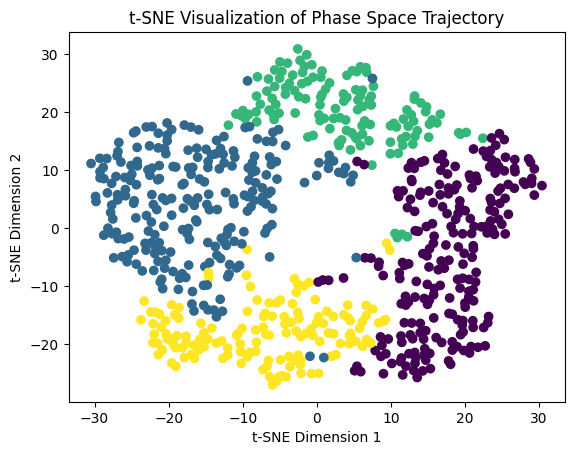

In [23]:
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=cluster_df['cluster'])
plt.title('t-SNE Visualization of Phase Space Trajectory')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

In [24]:
cluster_df

,0,1,2,3,4,cluster
0,20.7,14.7,3.4,3.5,7.3,0
1,17.9,11.8,5.4,3.2,12.9,0
2,18.8,11.3,9.6,5.7,7.8,0
3,14.6,10.6,11.5,7.7,6.2,0
4,15.8,11.7,12.3,9.0,5.6,0
...,...,...,...,...,...,...
715,15.8,16.9,13.0,6.5,12.9,0
716,13.0,19.1,11.6,7.9,7.7,0
717,13.0,20.4,13.0,4.1,7.6,0
718,13.7,20.1,11.2,5.4,3.5,0


Найдем вероятности состояний